# Binary neural network

On veux tester la binarisation des poids du réseau neuronal durant l'apprentissage.
On le test sur CIFAR-10.

## Import Modules

In [112]:
# Use GPU for Theano, comment to use CPU instead of GPU
# Tensorflow uses GPU by default
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

In [113]:
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

In [114]:
# To visiualize models
from keras.utils import plot_model

# If using tensorflow, set image dimensions order
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

## Binary nn

In [115]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler
# Evolution of learning rate

from binary_ops import binary_tanh as binary_tanh_op
from binary_layers import BinaryDense, BinaryConv2D, Clip

class DropoutNoScale(Dropout):
    '''Keras Dropout does scale the input in training phase, which is undesirable here.
    '''
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed) * (1 - self.rate)
            return K.in_train_phase(dropped_inputs, inputs,
                                    training=training)
        return inputs

def binary_tanh(x):
    return binary_tanh_op(x)

## Pre-processings : 

- Global contrast normalization
- ZCA whitening

In [116]:
import numpy as np
import scipy
import scipy.misc
from PIL import Image
from __future__ import division

def normalization(X, up):
    """ Normalize X beetween its minimum and up """
    return (X - np.min(X)) * up / (np.max(X) - np.min(X))

def global_contrast_normalization(Y):
    """ Return image after GCN """
    X = Y.copy()
    average = np.mean(X)
    dev_stand = np.std(X)
    
    for i in range(0, len(X)):
        av = X[i] - average
        dev = av / dev_stand
        #X[i] = normalization(dev, 254.0)
        X[i] = (dev - np.min(dev)) * 254.0 / (np.max(dev) - np.min(dev))
    return X
    
def zca_whiten(x_train, y_train):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X_train and y_train
    OUTPUT: Whiten X_train
    """
    # Attention, fonction sale
    datagen = ImageDataGenerator(zca_whitening=True)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)

    flow = datagen.flow(x_train, y_train, batch_size=1, shuffle=False)

    whiten_images = []

    for _ in range(x_train.shape[0]):
        x, y = flow.next()
        img = normalization(x[0], 1.0)
        whiten_images.append(img)
        
    return np.array(whiten_images)

## Function to load outside CIFAR-10 images

In [169]:
import cv2

#Choisit le test set
#Source = blurred, normal, etc..
classes = ['airplanes', 'automobiles', 'birds', 'cats', 'deers', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

def pick_test_set(source="cifar10"):
    # Resized, Rotated, Blurred, ColorsInverted, ContrastDecrease, HighContrast, LowContrast, Noisy, NoisyBlur, NoisyRotated, Others
    images = []
    labels = []
    for dossier, sous_dossiers, fichiers in os.walk("Images/" + source):
        split = dossier.split("/")
        classe = ""
        if (len(split) >=3):
            classe = split[2]
            #print("Processing " + classe + "...")
        
        #Pour l'instant on ne garde que les vraies classes
        if (classe != "birdogs" and classe != "birdsdogs" and classe != "catsdogs" and classe != "others"):
            print("Processing " + classe + "...")
            
            for fichier in fichiers: #Pour chaque image

                path = dossier + "/"+ fichier
                img = cv2.imread(path)
                img = img[:,:,::-1] # BGR to RGB
                # print(img.shape)
                # TODO
                image = np.transpose(np.reshape(img,(32,32,3)), (2,0,1)) # To CIFAR format
                
                labels.append([classes.index(classe)])
                images.append(image)
                
    return np.array(images), np.array(labels)

def pick_unique_class(source):
    images = []
    labels = []
    if source == "birdogs" or source == "birdsdogs" or source=="catsdogs":
        #"Images/Resized/" + source
        dossier = "Images/Resized/"+source
        for fichier in os.listdir(dossier):
            if not os.path.isdir(fichier):
                path = dossier + "/"+ fichier
                img = cv2.imread(path)
                img = img[:,:,::-1]
                image = np.transpose(np.reshape(img,(32,32,3)), (2,0,1)) # To CIFAR format
                labels.append([0])
                images.append(image)     
    else:
        dossier = "Images/Resized/others"
        for fichier in os.listdir(dossier):
            if not os.path.isdir(fichier):
                if source in fichier: 
                    path = dossier + "/"+ fichier
                    img = cv2.imread(path)
                    img = img[:,:,::-1]
                    image = np.transpose(np.reshape(img,(32,32,3)), (2,0,1)) # To CIFAR format
                    labels.append([0])
                    images.append(image)
        
    return np.array(images), np.array(labels)

## Load CIFAR10 Dataset and Test data

In [118]:
# Choosing test data between : cifar10, Resized, Rotated, Blurred, ColorsInverted, ContrastDecrease, 
#                              HighContrast, LowContrast, Noisy, NoisyBlur, NoisyRotated, Others
source = "cifar10"
##################

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

if source != "cifar10":
    # USE OUR TEST DATA
    test_features, test_labels = pick_test_set(source)

num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## Save or load pre-processed images

In [119]:
import pickle

def dump_data(data, data_file):
    # Save
    print("Saving data to {}".format(data_file))
    output = open(data_file, 'wb')
    pickle.dump(data, output)
    output.close()

def load_data(data_file):
    # Load
    print("Load data from {}".format(data_file))
    pkl_file = open(data_file, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

## Data pre-processing

In [120]:
def preprocessing(features, labels, gcn=False, zca=False):
    # Preprocessing on features
    
    if gcn:
        # Global Contrast Normalization
        print("Global Contrast Normalization...")
        for i in range(len(features)):
            features[i] = global_contrast_normalization(features[i])

    # Pre-processing
    features = features.astype('float32')/255
    
    if zca:
        # ZCA whitening
        print("ZCA Whitening...")
        features = zca_whiten(features, labels) 
    
    return features

In [73]:
# Dossier Images/PKL

# If using long processings
load = False
save = False

path = "Images/PKL/"
if not os.path.exists(path):
    os.makedirs(path)
    
train_file = "train.pkl"
test_file = source + ".pkl"

# If train features already preprocessed 
if os.path.exists(path + train_file) and load: # 50000 CIFAR-10 images
    print("Loading train : {}".format(train_file))
    train_features = load_data(path + train_file)

else:
    print("Processing train features")
    train_features = preprocessing(train_features, train_labels, gcn=True)
    if save:
        dump_data(train_features, path + train_file)

# If test features already preprocessed
if os.path.exists(path + test_file) and load:
    print("Loading test : {}".format(test_file))
    test_features = load_data(path + test_file)
    
else:
    print("Processing test : {}".format(source))
    test_features = preprocessing(test_features, test_labels, gcn=True)
    if save:
        dump_data(test_features, path + test_file)

Processing train features
Global Contrast Normalization...
Processing test : cifar10
Global Contrast Normalization...


In [121]:
train_features.shape

(50000, 3, 32, 32)

## Show Examples from Each Class

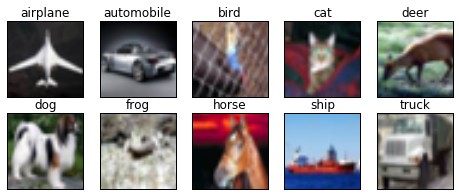

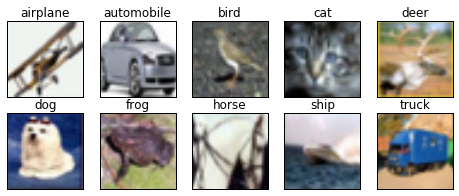

In [75]:
def show_examples(features, labels):

    class_names = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']
    fig = plt.figure(figsize=(8,3))
    for i in range(num_classes):
        ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
        idx = np.where(labels[:]==i)[0]
        features_idx = features[idx,::]
        img_num = np.random.randint(features_idx.shape[0])
        im = np.transpose(features_idx[img_num,::], (1, 2, 0))
        ax.set_title(class_names[i])
        plt.imshow(im)
    plt.show()
    
show_examples(train_features, train_labels)
show_examples(test_features, test_labels)

## Convert class labels to binary class labels

In [76]:
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Function to plot model accuracy and loss 

In [122]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Funtion to compute test accuracy

In [123]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Function to train the network

In [124]:
def train(model, callbacks=None, nb_epoch=10, batch_size=128, verbose=1, lr_start=1e-3, lr_end=1e-4, save=False, h5_file="model.h5"):
    # Train the model
    
    lr_decay = (lr_end / lr_start)**(1. / nb_epoch)
    
    if callbacks==None:
        lr_scheduler = LearningRateScheduler(lambda e: lr_start * lr_decay ** e)
        callbacks = [lr_scheduler]
    
    start = time.time()
    if save: # Boolean save means we save the model at each epoch
        for i in range(nb_epoch):
            print("Epoch : {}/{}".format(i+1, nb_epoch))
            model_info = model.fit(train_features, train_labels, 
                               batch_size=batch_size, nb_epoch=1, 
                               validation_data = (test_features, test_labels), 
                               verbose=verbose, callbacks=callbacks)
            save_weights(model, h5_file)
        
    else:
        model_info = model.fit(train_features, train_labels, 
                               batch_size=batch_size, nb_epoch=nb_epoch, 
                               validation_data = (test_features, test_labels), 
                               verbose=verbose, callbacks=callbacks)
    end = time.time()
    # plot model history
    plot_model_history(model_info)
    print(type(model_info))
    print("Model took %0.2f seconds to train"%(end - start))
    # compute test accuracy
    print("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## Simple network, without binarization

In [83]:
num_unit = 100
num_hidden = 3
lr_start = 1e-3

# BN
epsilon = 1e-6
momentum = 0.9

# Define the model
model = Sequential()

# Simple layer
model.add(Flatten(input_shape=(3, 32, 32)))
for i in range(num_hidden):
    model.add(Dense(num_unit, activation='tanh'))
    model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn{}'.format(i)))

# Output layer
model.add(Dense(num_classes, activation='softmax')) # 10SVM (L2-SVM) coming soon

# Display
# model.summary()

# Compile the model
model.compile(loss='squared_hinge', optimizer=Adam(lr=lr_start), metrics=['acc'])

# Train the model
train(model, nb_epoch=200)

print("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Loaded model from disk
Accuracy on test data is: 37.10


## Simple network, with binarization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
drop0 (DropoutNoScale)       (None, 3, 32, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense1 (BinaryDense)         (None, 100)               307200    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 100)               400       
_________________________________________________________________
act1 (Activation)            (None, 100)               0         
_________________________________________________________________
drop1 (DropoutNoScale)       (None, 100)               0         
_________________________________________________________________
dense2 (BinaryDense)         (None, 100)               10000     
__________

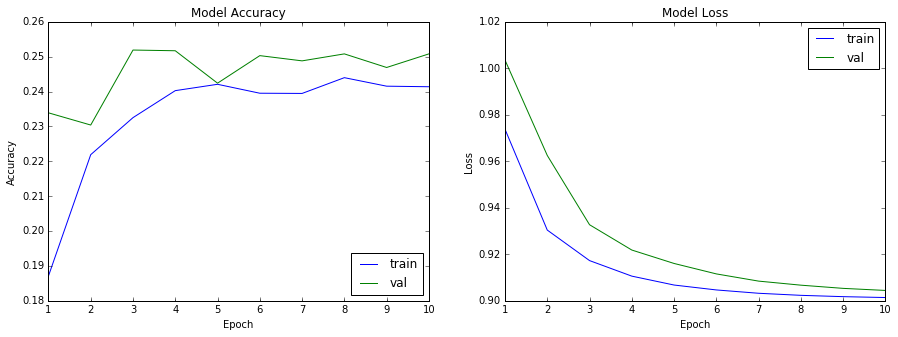

<class 'keras.callbacks.History'>
Model took 108.07 seconds to train
Accuracy on test data is: 25.08
Saved model to disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
drop0 (DropoutNoScale)       (None, 3, 32, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense1 (BinaryDense)         (None, 100)               307200    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 100)               400       
_________________________________________________________________
act1 (Activation)            (None, 100)               0         
_________________________________________________________________
drop1 (DropoutNoScale)       (None, 100)               0         
_____________________

In [38]:
deterministic = True # deterministic or stochastic binarization

H = 'Glorot'

# network
num_unit = 100
num_hidden = 3
use_bias = False

# BN
epsilon = 1e-6
momentum = 0.9

# dropout
drop_in = 0.2
drop_hidden = 0.5

# lr
lr_start = 1e-3

model = Sequential()
model.add(DropoutNoScale(drop_in, input_shape=(3, 32, 32), name='drop0'))
model.add(Flatten())
for i in range(num_hidden):
    model.add(BinaryDense(num_unit, H=H, use_bias=use_bias, # deterministic=deterministic
              name='dense{}'.format(i+1)))
    model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn{}'.format(i+1)))
    model.add(Activation(binary_tanh, name='act{}'.format(i+1)))
    model.add(DropoutNoScale(drop_hidden, name='drop{}'.format(i+1)))
# Output layer
model.add(BinaryDense(10, H=H, use_bias=use_bias, # deterministic=deterministic
          name='dense'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn'))

# Display
# model.summary()
    
model.compile(loss='squared_hinge', optimizer=Adam(lr=lr_start), metrics=['acc'])

# Train the model
train(model, lr_start=lr_start)

## Paper's architecture, without binarization

In [ ]:
h5_file = "paper_nb.h5"
from keras.regularizers import l2

# BN
epsilon = 1e-6
momentum = 0.9

# Kernel size and Pooling
kernel_size = (3, 3)
pool_size = (2, 2)

# Define the model
model = Sequential()

# (2 * 128C3)
model.add(Convolution2D(128, kernel_size=kernel_size, border_mode='same', input_shape=(3, 32, 32), activation='relu'))
model.add(Convolution2D(128, kernel_size=kernel_size, activation='relu'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn1'.format(i)))

# MP2
model.add(MaxPooling2D(pool_size=pool_size))
# model.add(Dropout(0.25)) # test

# (2 * 256C3)
model.add(Convolution2D(256, kernel_size=kernel_size, border_mode='same', activation='relu'))
model.add(Convolution2D(256, kernel_size=kernel_size, activation='relu'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn2'.format(i)))

# MP2
model.add(MaxPooling2D(pool_size=pool_size))

# (2 * 512C3)
model.add(Convolution2D(512, kernel_size=kernel_size, border_mode='same', activation='relu'))
model.add(Convolution2D(512, kernel_size=kernel_size, activation='relu'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn3'.format(i)))

# MP2
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten()) # Flat before FC

# (2 * 1024FC)
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn4'.format(i)))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn5'.format(i)))

# Output layer
model.add(Dense(num_classes, activation='linear', W_regularizer=l2(0.01))) # 10SVM (L2-SVM) 

# Display
# model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model
#print("Model loaded from disk")
# model.load_weights(h5_file)

# Train the model
train(model, nb_epoch=10)

# Save the model
#print("Model saved to disk")
# model.save_weights(h5_file)

## Paper's architecture, with binarization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (BinaryConv2D)         (None, 128, 32, 32)       3456      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 128, 32, 32)       512       
_________________________________________________________________
act1 (Activation)            (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (BinaryConv2D)         (None, 128, 32, 32)       147456    
_________________________________________________________________
bn2 (BatchNormalization)     (None, 128, 32, 32)       512       
_________________________________________________________________
act2 (Activation)            (None, 128, 32, 32)       0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 16, 16)       0         
__________

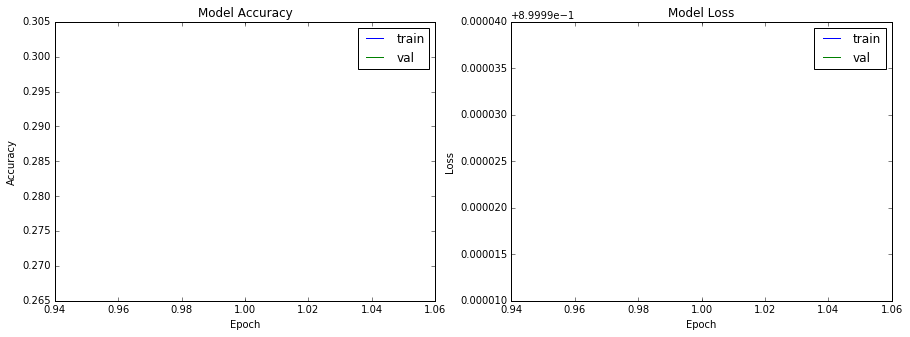

<class 'keras.callbacks.History'>
Model took 143868.38 seconds to train
Accuracy on test data is: 30.23


In [23]:
h5_file = "binary.h5"

# Currently disabled
deterministic = True # deterministic or stochastic binarization

H = 'Glorot'
kernel_lr_multiplier = 'Glorot'

# network
num_unit = 100
num_hidden = 3
use_bias = False

# Conv kernel and Pooling size
kernel_size = (3, 3)
pool_size = (2, 2)

# BN
epsilon = 1e-6
momentum = 0.9

# dropout
drop_in = 0.2
drop_hidden = 0.5

# lr
lr_start = 1e-3

# Define the model
model = Sequential()

# (2 * 128C3)
model.add(BinaryConv2D(128, deterministic=deterministic, kernel_size=kernel_size, input_shape=(3, 32, 32),
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv1'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn1'))
model.add(Activation(binary_tanh, name='act1'))

model.add(BinaryConv2D(128, deterministic=deterministic, kernel_size=kernel_size,
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv2'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn2'))
model.add(Activation(binary_tanh, name='act2'))

# MP2
model.add(MaxPooling2D(pool_size=pool_size, name='pool1', data_format='channels_first'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn3'))
model.add(Activation(binary_tanh, name='act3'))

# (2 * 256C3)
model.add(BinaryConv2D(256, deterministic=deterministic, kernel_size=kernel_size, input_shape=(3, 32, 32),
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv3'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn4'))
model.add(Activation(binary_tanh, name='act4'))

model.add(BinaryConv2D(256, deterministic=deterministic, kernel_size=kernel_size,
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv4'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn5'))
model.add(Activation(binary_tanh, name='act5'))

# MP2
model.add(MaxPooling2D(pool_size=pool_size, name='pool2', data_format='channels_first'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn6'))
model.add(Activation(binary_tanh, name='act6'))

# (2 * 512C3)
model.add(BinaryConv2D(512, deterministic=deterministic, kernel_size=kernel_size, input_shape=(3, 32, 32),
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv5'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn7'))
model.add(Activation(binary_tanh, name='act7'))

model.add(BinaryConv2D(512, deterministic=deterministic, kernel_size=kernel_size,
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv6'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn8'))
model.add(Activation(binary_tanh, name='act8'))

# MP2
model.add(MaxPooling2D(pool_size=pool_size, name='pool3', data_format='channels_first'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn9'))
model.add(Activation(binary_tanh, name='act9'))

# Flat before FC
model.add(Flatten()) 

# (2 * 1024FC)

model.add(BinaryDense(1024, H=H, use_bias=use_bias,
          name='dense1'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn10'))
model.add(Activation(binary_tanh, name='act10'))
model.add(DropoutNoScale(drop_hidden, name='drop1'))

model.add(BinaryDense(1024, H=H, use_bias=use_bias,
          name='dense2'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn11'))
model.add(Activation(binary_tanh, name='act11'))
model.add(DropoutNoScale(drop_hidden, name='drop2'))

# Output layer
model.add(BinaryDense(10, H=H, use_bias=use_bias,
          name='dense'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn'))
#model.add(Dense(num_classes, activation='linear', W_regularizer=l2(0.01))) # 10SVM (L2-SVM) 

# Compile the model
model.compile(loss='squared_hinge', optimizer=Adam(lr=lr_start), metrics=['acc'])

# Display
model.summary()

# Load the model
print("Model loaded from disk")
model.load_weights(h5_file)

# Train the model
train(model, lr_start=lr_start, save=True, h5_file=h5_file, batch_size=50)

# Save the model
#print("Model saved to disk")
# model.save_weights(h5_file)

## Convolution network, without binarization

In [92]:
num_unit = 100
num_hidden = 3
lr_start = 1e-3

# BN
epsilon = 1e-6
momentum = 0.9

# Kernel size and Pooling
kernel_size = (3, 3)
pool_size = (2, 2)

# Create the model
model = Sequential()

model.add(Convolution2D(32, kernel_size=kernel_size, activation='relu', border_mode='same', input_shape=(3, 32, 32)))
model.add(Dropout(0.2))
model.add(Convolution2D(32, kernel_size=kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Display
# model.summary()

# Compile the model
model.compile(loss='squared_hinge', optimizer=Adam(lr=lr_start), metrics=['acc'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
train(model, nb_epoch=5)#, save=True, h5_file=h5_file, nb_epoch=100)

print("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, padding="same", activation="relu", input_shape=(3, 32, 32..., kernel_size=(3, 3))`


Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 765s 15ms/step - loss: 0.9533 - acc: 0.4057 - val_loss: 0.9415 - val_acc: 0.5275
Epoch 2/5
  640/50000 [..............................] - ETA: 10:14 - loss: 0.9434 - acc: 0.5062

KeyboardInterrupt: 

## Convolution network, with binarization

In [110]:
h5_file = "binary_conv.h5"

# Currently disabled
deterministic = True # deterministic or stochastic binarization

H = 'Glorot'
kernel_lr_multiplier = 'Glorot'

# network
num_unit = 100
num_hidden = 3
use_bias = False

# Conv kernel and Pooling size
kernel_size = (3, 3)
pool_size = (2, 2)

# BN
epsilon = 1e-6
momentum = 0.9

# dropout
drop_in = 0.2
drop_hidden = 0.5

# lr
lr_start = 1e-3

# Create the model
model = Sequential()

# Conv2d 32
model.add(BinaryConv2D(32, deterministic=deterministic, kernel_size=kernel_size, input_shape=(3, 32, 32),
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv1'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn1'))
model.add(Activation(binary_tanh, name='act1'))

model.add(Dropout(0.2, name='drop1'))

# Conv2d 32
model.add(BinaryConv2D(32, deterministic=deterministic, kernel_size=kernel_size,
                       data_format='channels_first',
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv2'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn2'))
model.add(Activation(binary_tanh, name='act2'))

# MP2
model.add(MaxPooling2D(pool_size=pool_size, name='pool1', data_format='channels_first'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, axis=1, name='bn3'))
model.add(Activation(binary_tanh, name='act3'))

model.add(Flatten())

# Dense 512
model.add(BinaryDense(512, H=H, use_bias=use_bias,
          name='dense1'))
model.add(BatchNormalization(epsilon=epsilon, momentum=momentum, name='bn4'))
model.add(Activation(binary_tanh, name='act4'))
model.add(DropoutNoScale(drop_hidden, name='drop2'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


# Compile the model
model.compile(loss='squared_hinge', optimizer=Adam(lr=lr_start), metrics=['acc'])

# Display
model.summary()

# Load the model
print("Model loaded from disk")
model.load_weights(h5_file)

# Train the model
train(model, nb_epoch=125, lr_start=lr_start, save=True, h5_file=h5_file, batch_size=32)

# Save the model
# print("Model saved to disk")
# model.save_weights(h5_file)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (BinaryConv2D)         (None, 32, 32, 32)        864       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 32, 32, 32)        128       
_________________________________________________________________
act1 (Activation)            (None, 32, 32, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (BinaryConv2D)         (None, 32, 32, 32)        9216      
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32, 32, 32)        128       
_________________________________________________________________
act2 (Activation)            (None, 32, 32, 32)        0         
__________

## Test the model on differents test sets

#### Choosing test data between : 
Multi-class : cifar10, Resized, Rotated, Blurred, ColorsInverted, ContrastDecrease, HighContrast, LowContrast, Noisy, NoisyBlur, NoisyRotated

One-class : birdogs, birdsdogs, catsdogs, cloud, fish, flower, helicopter, lion, moto, noise, sea, snake, train, tree 

In [153]:
from matplotlib.ticker import MultipleLocator

def plot_confusion_matrix(cm, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    
    # Force multi labels
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Test set : cifar10
Global Contrast Normalization...


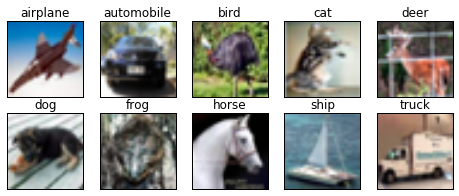

10000/10000 [==============================] - 149s 15ms/step

Report
             precision    recall  f1-score   support

   airplane      0.603     0.302     0.402      1000
 automobile      0.652     0.490     0.559      1000
       bird      0.444     0.241     0.312      1000
        cat      0.257     0.292     0.273      1000
       deer      0.559     0.085     0.148      1000
        dog      0.274     0.642     0.384      1000
       frog      0.617     0.283     0.388      1000
      horse      0.411     0.549     0.470      1000
       ship      0.482     0.689     0.567      1000
      truck      0.453     0.612     0.520      1000

avg / total      0.475     0.418     0.403     10000


Confusion matrix


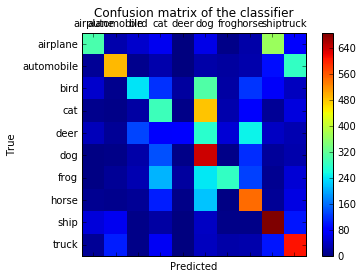




Processing ...
Processing ships...
Processing deers...
Processing frogs...
Processing trucks...
Processing cats...
Processing dogs...
Processing birds...
Processing airplanes...
Processing automobiles...
Processing horses...

Test set : Resized
Global Contrast Normalization...


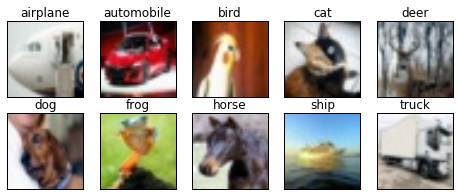

1370/1370 [==============================] - 22s 16ms/step

Report
             precision    recall  f1-score   support

   airplane      0.788     0.488     0.603       168
 automobile      0.897     0.473     0.619       110
       bird      0.481     0.281     0.355       185
        cat      0.355     0.227     0.277       172
       deer      0.500     0.115     0.186       131
        dog      0.182     0.533     0.271       120
       frog      0.849     0.302     0.446       149
      horse      0.309     0.527     0.389       112
       ship      0.439     0.838     0.576       117
      truck      0.525     0.698     0.599       106

avg / total      0.538     0.423     0.424      1370


Confusion matrix


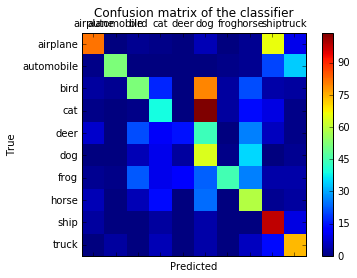




Processing ...
Processing ships...
Processing deers...
Processing frogs...
Processing trucks...
Processing cats...
Processing dogs...
Processing birds...
Processing airplanes...
Processing automobiles...
Processing horses...

Test set : Noisy
Global Contrast Normalization...


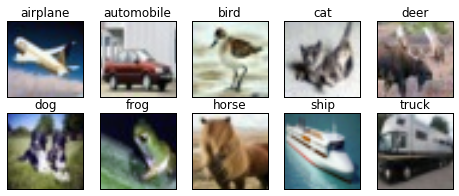

1370/1370 [==============================] - 21s 15ms/step

Report
             precision    recall  f1-score   support

   airplane      0.784     0.476     0.593       168
 automobile      0.857     0.491     0.624       110
       bird      0.519     0.292     0.374       185
        cat      0.359     0.244     0.291       172
       deer      0.457     0.122     0.193       131
        dog      0.191     0.583     0.287       120
       frog      0.854     0.275     0.416       149
      horse      0.328     0.518     0.401       112
       ship      0.451     0.829     0.584       117
      truck      0.500     0.670     0.573       106

avg / total      0.538     0.426     0.426      1370


Confusion matrix


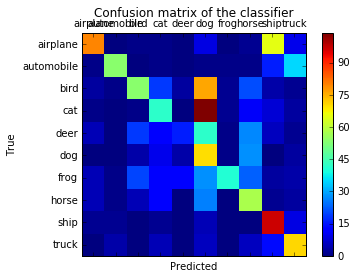




Processing ...
Processing ships...
Processing deers...
Processing frogs...
Processing trucks...
Processing cats...
Processing dogs...
Processing birds...
Processing airplanes...
Processing automobiles...
Processing horses...

Test set : Rotated
Global Contrast Normalization...


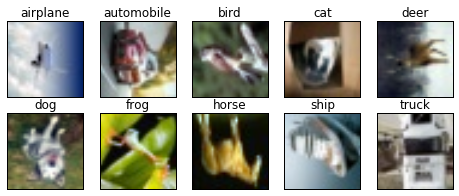

1370/1370 [==============================] - 21s 15ms/step

Report
             precision    recall  f1-score   support

   airplane      0.470     0.369     0.413       168
 automobile      0.262     0.145     0.187       110
       bird      0.293     0.195     0.234       185
        cat      0.193     0.198     0.195       172
       deer      0.179     0.038     0.063       131
        dog      0.069     0.292     0.111       120
       frog      0.638     0.248     0.357       149
      horse      0.061     0.089     0.073       112
       ship      0.110     0.068     0.084       117
      truck      0.043     0.019     0.026       106

avg / total      0.253     0.179     0.192      1370


Confusion matrix


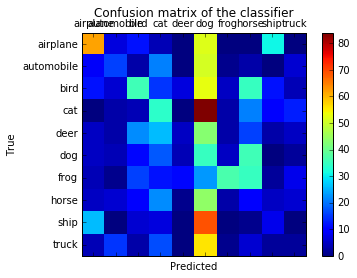




Processing ...
Processing ships...
Processing deers...
Processing frogs...
Processing trucks...
Processing cats...
Processing dogs...
Processing birds...
Processing airplanes...
Processing automobiles...
Processing horses...

Test set : Blurred
Global Contrast Normalization...


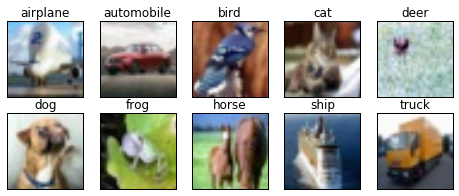

1370/1370 [==============================] - 22s 16ms/step

Report
             precision    recall  f1-score   support

   airplane      0.792     0.476     0.595       168
 automobile      0.883     0.482     0.624       110
       bird      0.481     0.281     0.355       185
        cat      0.359     0.244     0.291       172
       deer      0.452     0.107     0.173       131
        dog      0.183     0.533     0.272       120
       frog      0.870     0.315     0.463       149
      horse      0.314     0.518     0.391       112
       ship      0.439     0.838     0.576       117
      truck      0.489     0.651     0.559       106

avg / total      0.533     0.421     0.423      1370


Confusion matrix


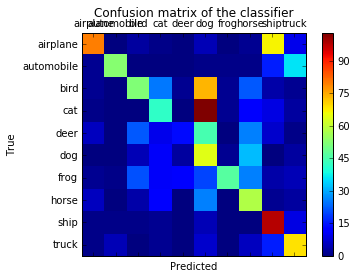




Processing ...
Processing ships...
Processing deers...
Processing frogs...
Processing trucks...
Processing cats...
Processing dogs...
Processing birds...
Processing airplanes...
Processing automobiles...
Processing horses...

Test set : ColorsInverted
Global Contrast Normalization...


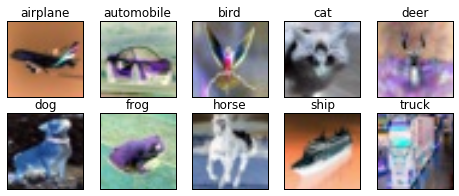

1370/1370 [==============================] - 22s 16ms/step

Report
             precision    recall  f1-score   support

   airplane      0.253     0.226     0.239       168
 automobile      0.200     0.309     0.243       110
       bird      0.195     0.081     0.115       185
        cat      0.134     0.157     0.145       172
       deer      0.500     0.015     0.030       131
        dog      0.090     0.375     0.145       120
       frog      0.000     0.000     0.000       149
      horse      0.000     0.000     0.000       112
       ship      0.027     0.034     0.030       117
      truck      0.022     0.019     0.020       106

avg / total      0.150     0.122     0.102      1370


Confusion matrix


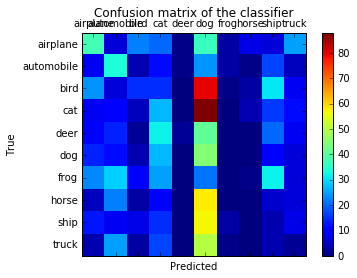




Processing ...
Processing ships...
Processing deers...
Processing frogs...
Processing trucks...
Processing cats...
Processing dogs...
Processing birds...
Processing airplanes...
Processing automobiles...
Processing horses...

Test set : ContrastDecrease
Global Contrast Normalization...


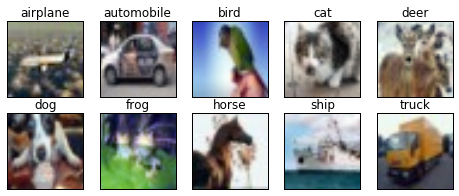

1370/1370 [==============================] - 22s 16ms/step

Report
             precision    recall  f1-score   support

   airplane      0.768     0.435     0.555       168
 automobile      0.871     0.491     0.628       110
       bird      0.478     0.292     0.362       185
        cat      0.336     0.209     0.258       172
       deer      0.485     0.122     0.195       131
        dog      0.172     0.550     0.262       120
       frog      0.795     0.208     0.330       149
      horse      0.327     0.482     0.390       112
       ship      0.414     0.846     0.556       117
      truck      0.485     0.613     0.542       106

avg / total      0.518     0.400     0.399      1370


Confusion matrix


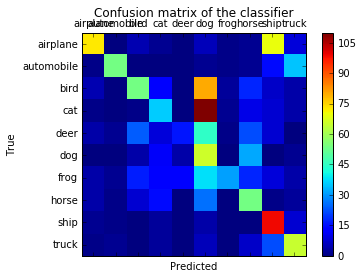




Processing ...
Processing ships...
Processing deers...
Processing frogs...
Processing trucks...
Processing cats...
Processing dogs...
Processing birds...
Processing airplanes...
Processing automobiles...
Processing horses...

Test set : HighContrast
Global Contrast Normalization...


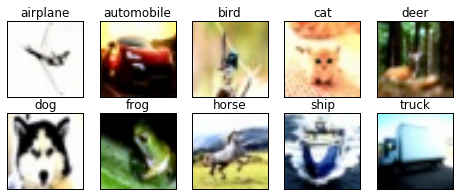

1370/1370 [==============================] - 21s 15ms/step

Report
             precision    recall  f1-score   support

   airplane      0.844     0.452     0.589       168
 automobile      0.800     0.618     0.697       110
       bird      0.403     0.168     0.237       185
        cat      0.373     0.331     0.351       172
       deer      0.359     0.107     0.165       131
        dog      0.190     0.400     0.257       120
       frog      0.695     0.383     0.494       149
      horse      0.256     0.500     0.338       112
       ship      0.460     0.880     0.604       117
      truck      0.507     0.708     0.591       106

avg / total      0.495     0.427     0.421      1370


Confusion matrix


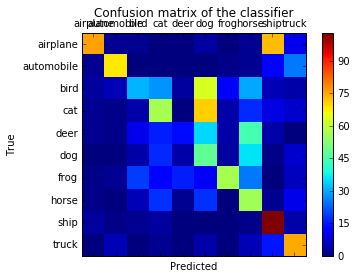




Processing ...
Processing ships...
Processing deers...
Processing frogs...
Processing trucks...
Processing cats...
Processing dogs...
Processing birds...
Processing airplanes...
Processing automobiles...
Processing horses...

Test set : LowContrast
Global Contrast Normalization...


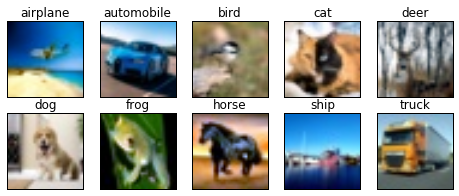

1370/1370 [==============================] - 21s 15ms/step

Report
             precision    recall  f1-score   support

   airplane      0.818     0.482     0.607       168
 automobile      0.838     0.518     0.640       110
       bird      0.481     0.281     0.355       185
        cat      0.347     0.250     0.291       172
       deer      0.531     0.130     0.209       131
        dog      0.180     0.483     0.262       120
       frog      0.839     0.349     0.493       149
      horse      0.283     0.518     0.366       112
       ship      0.466     0.829     0.597       117
      truck      0.500     0.670     0.573       106

avg / total      0.536     0.428     0.432      1370


Confusion matrix


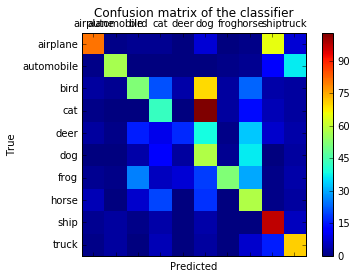




Processing ...
Processing ships...
Processing deers...
Processing frogs...
Processing trucks...
Processing cats...
Processing dogs...
Processing birds...
Processing airplanes...
Processing automobiles...
Processing horses...

Test set : NoisyBlur
Global Contrast Normalization...


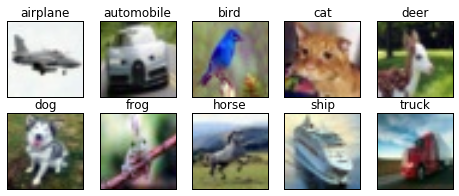

1370/1370 [==============================] - 21s 16ms/step

Report
             precision    recall  f1-score   support

   airplane      0.771     0.440     0.561       168
 automobile      0.883     0.482     0.624       110
       bird      0.504     0.308     0.383       185
        cat      0.371     0.267     0.311       172
       deer      0.455     0.115     0.183       131
        dog      0.185     0.525     0.274       120
       frog      0.860     0.329     0.476       149
      horse      0.306     0.491     0.377       112
       ship      0.439     0.829     0.574       117
      truck      0.500     0.689     0.579       106

avg / total      0.534     0.425     0.427      1370


Confusion matrix


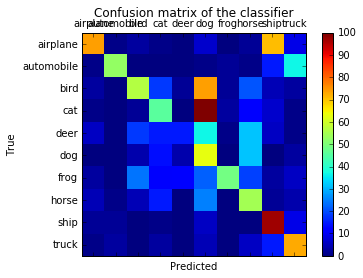




Processing ...
Processing ships...
Processing deers...
Processing frogs...
Processing trucks...
Processing cats...
Processing dogs...
Processing birds...
Processing airplanes...
Processing automobiles...
Processing horses...

Test set : NoisyRotated
Global Contrast Normalization...


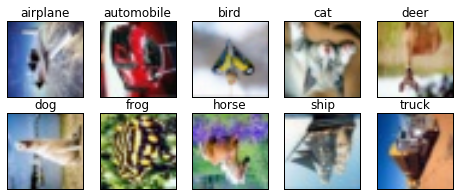

1370/1370 [==============================] - 22s 16ms/step

Report
             precision    recall  f1-score   support

   airplane      0.500     0.327     0.396       168
 automobile      0.281     0.145     0.192       110
       bird      0.268     0.200     0.229       185
        cat      0.179     0.203     0.191       172
       deer      0.238     0.038     0.066       131
        dog      0.066     0.283     0.107       120
       frog      0.661     0.275     0.389       149
      horse      0.076     0.089     0.082       112
       ship      0.155     0.094     0.117       117
      truck      0.087     0.057     0.069       106

avg / total      0.269     0.182     0.199      1370


Confusion matrix


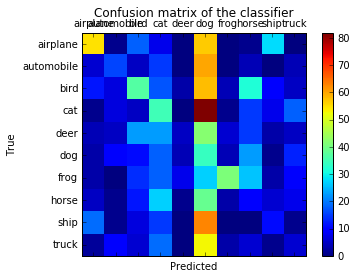





Test set : birdogs
Global Contrast Normalization...
49/49 [==============================] - 1s 16ms/step
airplane : 0.00907658785582
automobile : 0.00372305396013
bird : 0.110605880618
cat : 0.186193004251
deer : 0.0156994070858
dog : 0.387752115726
frog : 0.0200115609914
horse : 0.131391227245
ship : 0.0491203926504
truck : 0.0864268317819

Test set : catsdogs
Global Contrast Normalization...
132/132 [==============================] - 2s 16ms/step
airplane : 3.24987886415e-05
automobile : 0.00465257512406
bird : 0.00706286914647
cat : 0.384601980448
deer : 0.0134936720133
dog : 0.379066228867
frog : 0.0243055913597
horse : 0.0949059650302
ship : 0.00229240767658
truck : 0.0895863473415

Test set : birdsdogs
Global Contrast Normalization...
29/29 [==============================] - 0s 15ms/step
airplane : 0.0158055536449
automobile : 3.38603626915e-06
bird : 0.0804469436407
cat : 0.394017130136
deer : 0.00400456180796
dog : 0.331878870726
frog : 0.0301570110023
horse : 0.0823360383

In [172]:
from sklearn.metrics import confusion_matrix, classification_report

sources_multi_class = ["cifar10", "Resized", "Noisy", "Rotated", "Blurred", "ColorsInverted", 
                       "ContrastDecrease", "HighContrast", "LowContrast", "NoisyBlur", "NoisyRotated"]
sources_one_class = ["birdogs", "catsdogs", "birdsdogs", "cloud", "fish", "flower", "helicopter", 
                     "lion", "moto", "noise", "sea", "snake", "train", "tree"]

for source in sources_multi_class:
    if source == "cifar10":
        (_, _), (test_features, test_labels) = cifar10.load_data()
    else:
        # Pick test set
        test_features, test_labels = pick_test_set(source)
        
    print("\nTest set : " + source)
    # Preprocessing
    test_features = preprocessing(test_features, test_labels, gcn=True)
    # Show examples
    show_examples(test_features, test_labels)
    
    # Predicting classes
    y_pred = model.predict(test_features, batch_size=32, verbose=1)
    target_names = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']
    predicted_classes = np.argmax(y_pred, axis=1)
    
    print("\nReport")
    print(classification_report(test_labels, predicted_classes, 
        target_names=target_names, digits = 3))
    print("\nConfusion matrix")
    
    cm = confusion_matrix(test_labels, predicted_classes)
    plot_confusion_matrix(cm, target_names)
    print("\n\n")

    
for source in sources_one_class:
    
    # Pick test set
    test_features, test_labels = pick_unique_class(source)    
    print("\nTest set : " + source)
    # Preprocessing
    test_features = preprocessing(test_features, test_labels, gcn=True)

    probas = model.predict_proba(test_features, batch_size=32, verbose=1)
    probas = probas.mean(axis=0) # moyenne
    class_names = ['airplane','automobile','bird','cat','deer',
                       'dog','frog','horse','ship','truck']
    for c, prop in zip(class_names, probas):
        print("{} : {}".format(c, prop))